<a href="https://colab.research.google.com/github/nina-adhikari/enjoyment-maximizing-maps/blob/main/mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# packages that need to be installed
!pip install mapclassify # Choropleth map classification; basically for Geopandas

In [2]:
# packages that need to be loaded
import matplotlib.pyplot as plt #for the pandas profiling
import geopandas as gpd #extends the datatypes used by pandas to allow spatial operations on geometric types
import pandas as pd
import numpy as np
import pickle

# 1. Importing and cleaning data

In [3]:
# global variables to be defined
DIR = 'drive/MyDrive/walkability/'   # directory where all files are stored
HEALTH_OUTCOME = 'LPA'

# datasets stored in drive/MyDrive/walkability/
health = DIR + 'health.csv'      # 500 Cities: Local Data for Better Health https://data.cdc.gov/500-Cities-Places/500-Cities-Local-Data-for-Better-Health-2019-relea/6vp6-wxuq/about_data
epacsv = DIR + 'epdownload.csv'  # Smart Location Database https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv
income = DIR + 'income.csv'      # Median household income https://data.census.gov/table/ACSDT5Y2017.B19013?q=b19013&g=040XX00US11$1400000&moe=false&tp=true
walk_gdb = DIR + 'walk_index.gdb'

# allow colab to access your Google Drive, an authentication window will pop-up
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Import the Income dataset:

In [4]:
inc = gpd.read_file(income).drop('geometry', axis=1)                            # converts GeoDataFrame to a normal DataFrame by dropping the geometry column?
inc['Income'] = inc['Income'].str.replace(',','')                               # replace comma format for numbers
inc = inc.apply(pd.to_numeric, errors='coerce')                                 # convert to numeric, coerce makes invalid parsing be set as NaN
inc['Tract'] = round(inc['Tract'].astype(float)*100).astype(int)                # format census tract id as integer
inc.set_index('Tract', inplace=True)                                            # tract id is the index of this dataframe

Import the SLD dataset:

In [5]:
columns_to_drop = ['GEOID20', 'CSA', 'CSA_Name', 'CBSA', 'CBSA_Name', 'CBSA_POP', 'CBSA_EMP', 'CBSA_WRK']
epa_init = gpd.read_file(epacsv, where="STATEFP='11'").drop(columns=columns_to_drop)   # only interested in DC

# GEO ID data is corrupted in csv because it was stored as a float, so we generate it using other data and padding
epa_init['GEOID10'] = epa_init['STATEFP'].str.zfill(2) + epa_init['COUNTYFP'].str.zfill(3) + epa_init['TRACTCE'].str.zfill(6) + epa_init['BLKGRPCE']

epa_init['TRACTCE'] = epa_init['TRACTCE'].astype(int)                           # format as integer to use for merging later
epa_init.set_index('OBJECTID', inplace=True)

Since the CSV doesn't have geometry data for plotting, we import it from another file (which comes from the same EPA dataset):

In [ ]:
gdb = gpd.read_file(walk_gdb, where="STATEFP='11'")[['GEOID10', 'geometry']]
gdb['GEOID10'] = gdb['GEOID10'].astype(int)
gdb.set_index('GEOID10', inplace=True)
epa_init['GEOID10'] = epa_init['GEOID10'].astype(int)
epa = epa_init.join(other=gdb, on='GEOID10', how='left', validate='1:1', lsuffix='epa')
epa.drop(columns=['geometryepa'], inplace=True)
epa

Import the health dataset:

In [7]:
hl = gpd.read_file(health, where="StateAbbr='DC' AND GeographicLevel='Census Tract'", include_fields=['StateAbbr', 'GeographicLevel', 'UniqueID', 'MeasureId', 'CityFIPS', 'TractFIPS', 'Data_Value'])
hl['TractCE'] = hl['TractFIPS'].str.removeprefix('110010').astype(int)          # format index column
hlp = hl.pivot(index='TractCE', columns='MeasureId', values='Data_Value')       # pivot table to have the columns be the MeasureId

Merge all datasets:

In [8]:
firstjoin = epa.join(other=inc, on='TRACTCE', how='left', validate='m:1')                   # merge EPA and income data
secondjoin = firstjoin.join(other=hlp[HEALTH_OUTCOME], on='TRACTCE', how='left', validate='m:1')     # merge above with CDC data
secondjoin = secondjoin.apply(pd.to_numeric, errors='ignore')
secondjoin

,GEOID10,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,TotPop,...,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area,geometry,Income,LPA
OBJECTID,,,,,,,,,,,,,,,,,,,,,
61344,110010040023,11,1,4002,3,16.948095,0.000000,16.948095,16.948095,553,...,17,10,19,19,17.166667,1201.674704,68587.96738,"MULTIPOLYGON (((1617361.678 1927352.465, 16173...",102455.0,12.6
61345,110010041001,11,1,4100,1,25.638849,0.000000,25.638849,24.554800,1210,...,13,16,20,19,17.833333,1328.833340,103759.02510,"MULTIPOLYGON (((1617028.696 1927124.163, 16170...",143586.0,14.3
61346,110010042022,11,1,4202,2,23.832548,0.000000,23.832548,23.832548,1188,...,17,12,20,18,17.500000,1450.239008,96448.75188,"MULTIPOLYGON (((1617427.574 1927158.696, 16174...",105978.0,12.7
61347,110010053014,11,1,5301,4,16.884343,0.000000,16.884343,16.884343,1150,...,16,16,12,19,15.666667,1158.771615,68329.30242,"MULTIPOLYGON (((1617857.365 1926906.416, 16178...",90402.0,13.6
61348,110010050021,11,1,5002,1,9.810858,0.000000,9.810858,9.810858,1739,...,4,5,16,19,13.166667,801.162123,39703.77108,"MULTIPOLYGON (((1618967.176 1926639.840, 16189...",87969.0,19.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61789,110010007022,11,1,702,2,18.081790,0.000000,18.081790,18.081790,1045,...,2,8,13,19,12.333333,1338.001954,73175.60627,"MULTIPOLYGON (((1614569.609 1927830.272, 16146...",71671.0,16.4
61790,110010007012,11,1,701,2,19.805559,0.000000,19.805559,18.978260,1080,...,3,7,12,19,12.000000,1175.108163,80152.05213,"MULTIPOLYGON (((1614183.231 1928298.295, 16141...",89889.0,17.1
61791,110010013023,11,1,1302,3,125.755120,1.303205,124.451915,108.547510,573,...,15,10,10,17,13.166667,4543.930515,508923.40880,"MULTIPOLYGON (((1615366.380 1930018.785, 16153...",113300.0,14.6


Further cleaning:

In [9]:
# Some of the entries are set to -99999 (see the PDF, page 23 footnote 65), so we will replace them (and in fact all negative entries) with NaN:
secondjoin[secondjoin.drop(columns=['geometry']) < 0] = np.nan

# Drop the rows that have NaNs
df_full = secondjoin.dropna()

# Columns we ignore when doing numerical operations
non_numeric_columns = ['GEOID10', 'STATEFP', 'COUNTYFP', 'TRACTCE', 'BLKGRPCE', 'Shape_Length', 'Shape_Area', 'geometry']

df_geo = df_full['geometry']                                                    # The GeoDataFrame that has mapping info
df = df_full.drop(columns=non_numeric_columns)                                  # The purely numeric dataframe that we will use for regressions

In [10]:
# open dictionary that contains the explanation of each column name
picklefile = DIR + 'cols_dict.pickle'
with open(picklefile, 'rb') as handle:
    cols_dict = pickle.load(handle)

# 2. Feature selection

In [25]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay


## a. Lasso

Set up some basic settings:

In [12]:
features = list(df.drop(columns=[HEALTH_OUTCOME]).columns)

## These are the features that need to be scaled
scale_columns = range(len(features))

ITERS = 5

#lasso hyperparameter
ALPHAS = [.0001,.001,.01,.1,.25,.5,.75,1,5,10,25,50,100,1000,10000] #15

SEED = 47
rng = np.random.default_rng(SEED)

In [13]:
MAX_ITERATIONS = 1000000
TOLERANCE = 0.001

def lasso_for_one_dataset(dataset, outcomes):
  #initialize min_idx array
  min_idx = np.zeros(len(features))

  ## make coefficient holder
  coefs = np.zeros((len(ALPHAS), len(features)))

  ## Loop through alphas
  for i in range(len(ALPHAS)):
    ## make lasso model
    lasso = Lasso(alpha=ALPHAS[i], max_iter=MAX_ITERATIONS, tol=TOLERANCE, fit_intercept=False)

    ## fit model
    lasso.fit(dataset, outcomes)

    ## record coefs
    coefs[i,:] = lasso.coef_
    coef_df = pd.DataFrame(data=coefs, index=ALPHAS, columns=features)
    prev_min_idx = min_idx
    min_idx = coef_df.ne(0).idxmin().values

    if (min_idx == prev_min_idx).all():
      break
  return min_idx

In [14]:
# We want to do the randomization multiple times
min_idx = np.zeros((len(features), ITERS))

# Get some random states
states = rng.integers(low=10, high=70, size=5)

for i in range(ITERS):
  ## make a train test split here
  df_copy = df.copy()
  urban_train, urban_test = train_test_split(
    df_copy,
    shuffle = True,
    random_state = states[i],
    test_size = .8
    )
  ## scale quantitative variables
  urban_train_array = urban_train[features].to_numpy()
  scaler = StandardScaler()

  urban_train_array_scaled = urban_train_array.copy()
  urban_train_array_scaled[:,scale_columns] = scaler.fit_transform(urban_train_array_scaled[:,scale_columns])

  min_idx[:,i] = lasso_for_one_dataset(urban_train_array_scaled, urban_train[HEALTH_OUTCOME].values)

min_idx_df = pd.DataFrame(data=min_idx, index=features, columns=range(ITERS))

In [15]:
#add a score col and sort
min_idx_df['score'] = np.round(min_idx_df.sum(axis=1, numeric_only=True), 1)
misorted = min_idx_df.sort_values(by=['score'], ascending=False)
misorted

,0,1,2,3,4,score
R_PCTLOWWAGE,10.0000,10.0000,10.0000,10.0000,10.0000,50.0
Income,10.0000,5.0000,10.0000,10.0000,10.0000,45.0
R_MedWageWk,5.0000,5.0000,5.0000,5.0000,5.0000,25.0
D5BR,5.0000,0.1000,5.0000,5.0000,0.1000,15.2
D5DR,5.0000,0.1000,0.7500,5.0000,0.1000,11.0
...,...,...,...,...,...,...
D1D,0.0001,0.0001,0.0001,0.0001,0.0001,0.0
Workers,0.0010,0.0001,0.0001,0.0001,0.0001,0.0
E5_Svc,0.0001,0.0001,0.0010,0.0010,0.0001,0.0
D3B,0.0001,0.0100,0.0001,0.0010,0.0001,0.0


Only keep features above a certain threshold:

In [16]:
THRESHOLD = 2.0

features_to_keep = list(misorted.loc[misorted['score'] >= THRESHOLD].index)
df_reg = df.copy()[features_to_keep]

scaler = StandardScaler().set_output(transform="pandas")
df_reg = scaler.fit_transform(df_reg)
df_reg[HEALTH_OUTCOME] = df[HEALTH_OUTCOME]
# df_reg = pd.DataFrame(data=df_reg, columns=features_to_keep)
df_reg

,R_PCTLOWWAGE,Income,R_MedWageWk,D5BR,D5DR,D5AR,D3AMM,D3B_Ranked,R_HiWageWk,D5CE,P_WrkAge,D5AE,D3AAO,D5DRI,Pct_AO1,AutoOwn2p,LPA
OBJECTID,,,,,,,,,,,,,,,,,
61344,-1.486964,0.345804,-1.289640,0.807350,0.807348,0.895403,-0.819282,0.798505,-0.400656,-0.294798,1.217360,-0.294810,-0.304156,0.807350,-0.122379,-1.243577,12.6
61345,-1.529314,1.234438,-0.908539,0.840877,0.840876,1.284131,0.118921,1.091071,0.417869,0.034741,0.673571,0.034749,-0.304156,0.840877,0.732039,-0.418345,14.3
61346,-1.491410,0.421918,-0.586069,1.185684,1.185685,1.993518,1.876371,1.091071,1.156753,0.900662,1.695235,0.900668,-0.304156,1.185684,-0.044304,-0.114950,12.7
61347,-1.108075,0.085399,-0.791277,1.385993,1.385994,1.889561,2.918289,-1.249463,1.285062,0.439368,0.978422,0.439363,-0.304156,1.385993,-0.986417,-1.279984,13.6
61348,-0.561780,0.032834,-0.038847,2.722571,2.722570,1.821014,0.135880,-0.079196,0.652365,0.570137,1.102011,0.570143,-0.304156,2.722571,-0.830432,-1.510563,19.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61789,-0.446425,-0.319284,-0.390632,0.117347,0.117346,0.232968,-0.996552,-0.956896,0.156826,-0.920242,1.794106,-0.920241,-0.304156,0.117347,-1.795083,-0.563974,16.4
61790,-1.347546,0.074315,-0.967170,-0.277734,-0.277734,0.112266,0.444207,-1.249463,-0.719217,-1.055668,0.311045,-1.055660,-0.304156,-0.277734,2.735198,-1.510563,17.1
61791,-1.262727,0.580110,-1.191922,1.115861,1.115862,-0.784098,-0.215422,-1.834597,-0.188282,-1.549012,-0.100917,-1.549008,-0.304156,1.115861,0.768381,-0.212037,14.6


# 3. Learning

## a. Linear Regression

In [17]:
lr = LinearRegression(copy_X=True)

X = df_reg.drop(columns=[HEALTH_OUTCOME])
y = df_reg[HEALTH_OUTCOME]

lr.fit(X, y)

LinearRegression()

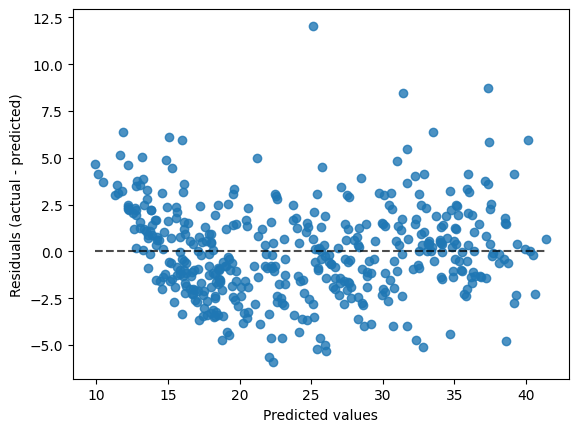

In [18]:
y_pred = lr.predict(X)
display = PredictionErrorDisplay(y_true=y, y_pred=y_pred)
display.plot()

In [ ]:
coeffs = pd.DataFrame(data=lr.coef_.round(2), index=X.columns)
coeffs

,0
R_PCTLOWWAGE,2.41
Income,-2.62
R_MedWageWk,1.35
D5BR,86696364.66
D5DR,356474.33
D5AR,-2.11
D3AMM,-0.23
D3B_Ranked,-0.15
R_HiWageWk,-0.53
D5CE,-4648.64


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
kf = KFold(shuffle=True, random_state=SEED)
lr = LinearRegression()


scores = cross_val_score(lr, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
scores

array([-6.33426367, -7.46078143, -7.0763722 , -7.86408006, -5.60341229])